# 1. Importación de librerías y carga de datos

In [1]:
SCALED=False
STANDARIZED=False

In [2]:
#from google.colab import drive

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from haversine import inverse_haversine, Direction
from attention import Attention

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

C:\Users\sandr\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Hacemos el resultado reproducible
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Declaramos el tipo de float, en este caso float64
tf.keras.backend.set_floatx('float64')

In [4]:
# Leemos y guardamos la info de segudo y vehículo
df = pd.read_csv('positions.csv')

df_data = df.sort_values(by=['vehicle_id', 'time(s)'])

columns = ['time(s)', 'vehicle_id']
df = df_data[columns]
df.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id
0,1.0,0
31,2.0,0
64,3.0,0
100,4.0,0
158,5.0,0


In [5]:
# Load MinMaxScaler for target variables
if SCALED:
    MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation",
                             #"data_preparation", "minmaxscaler.pkl")
    with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
        minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
    TARGETS_STAND_FILE = './' #os.path.join("TFM", "implementation",
                                     #"data_preparation", "targets_stand.pkl")
    with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
        standscaler_targets = pickle.load(f_scaler)

In [6]:
# Load training dataset
if SCALED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val.npz")
    
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_stand.npz")
else:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (6005877, 20, 5)  y_train: (6005877, 5, 5)
X_val: (2573948, 20, 5)  y_val: (2573948, 5, 5)
X_test: (2402, 20, 5)  y_test: (2402, 5, 5)
Vehicle_ids: 8972


In [7]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join('./', "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,0,5.0,1.8
1,2,5.0,1.8
2,3,5.0,1.8
3,4,2.2,0.9
4,5,5.0,1.8


In [8]:
# Load dataset with vehicles colision
#DATASET_COL = os.path.join('./', "collisions_1k.csv")
df_col = pd.read_csv('collisions_2k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,1240,5722
1,209,802
2,863,300
3,6444,3528
4,798,2787


In [9]:
# Load dataset with vehicles no-colision
#DATASET_NOCOL = os.path.join('./', "no_collisions_1k.csv")
df_nocol = pd.read_csv('no_collisions_2k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,31477,34003
1,33063,33228
2,33130,33973
3,33268,33958
4,33268,34256


In [10]:
df_col.shape

(2120, 2)

In [11]:
df_nocol.shape

(2120, 2)

# 2. Generación y entrenamiento de los modelos

In [12]:
#if SCALED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
#elif STANDARIZED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
#else:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")
    
MODELS_FOLDER = './'

In [13]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter

# Windows parameters
INPUT_WIDTH = 20
OUTPUT_WIDTH = 5
OFFSET_WIDTH = 0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']

# Training parameters
EPOCHS = 10
BATCH_SIZE = 64
PATIENCE = 3
REDUCELR = 0.2

def physics_loss(y_true, y_pred):
     # Para facilitar el cálculo, hacemos un reshape de y_true para juntar las 64 muestras (batch_size)
    a,b,c = tf.shape(y_true)
    y_true = tf.reshape(y_true, [a.numpy()*b.numpy(),c.numpy()])
    y_pred = tf.reshape(y_pred, [a.numpy()*b.numpy(),c.numpy()])
    
    
    # Calculamos velocidades y aceleraciones
    vx = tf.gather(y_true,[3],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    vy = tf.gather(y_true,[3],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))
    ax = tf.gather(y_true,[4],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    ay = tf.gather(y_true,[4],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))

    # Aplicamos las ecuaciones del movimiento para obtener la distancia recorrida en metros
    dist_lat_m = vy + ay/2
    dist_lon_m = vx + ax/2

    # Pasamos la distancia recorrida en metros a las distancias en latitud longitud
    dist_lat = (dist_lat_m/6371000)*(180/math.pi)
    dist_lon = (dist_lon_m/6371000)*(180/math.pi) / tf.math.cos(tf.gather(y_true,[0],axis=1) * math.pi/180)

    # Calculamos las nuevas latitud y longitud
    pred_latitude = tf.gather(y_true,[0],axis=1) + dist_lat
    pred_longitude = tf.gather(y_true,[1],axis=1) + dist_lon
    
    # La pérdida será reducir la distancia entre las predichas y las calculadas físicamente
    loss = tf.reduce_mean(tf.square(pred_latitude -tf.gather(y_pred,[0],axis=1)) 
                          + tf.square(pred_longitude -tf.gather(y_pred,[1],axis=1)))
    
    return loss

def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
    tracker = EmissionsTracker(log_level="error")
    callback_list = []

    # Return best model that minimize loss function
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience*2, mode='min',
        restore_best_weights=True)
    callback_list.append(early_stopping)

    # Save best model that minimize loss function
    checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_file, monitor='val_loss', mode="min",
        save_best_only=True, verbose=0)
    callback_list.append(checkpoint)
  
    if reduce_lr != 0:
        # Reduce learning rate to minimize loss function
        reduce_learningrate = ReduceLROnPlateau(
            monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
        callback_list.append(reduce_learningrate)

    model.compile(loss=physics_loss,
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    tracker.start()
    start_time = time.time()
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)

    # Define state transition function for UKF
    def fx(x, dt):
        # Implement the state transition function
        # Assuming a simple constant velocity model for demonstration
        # x: State vector [latitude, longitude, heading, speed, acceleration]
        # dt: Time step

        # Extracting state variables
        latitude = x[0]
        longitude = x[1]
        heading = x[2]
        speed = x[3]
        acceleration = x[4]

        # Update the state based on a constant velocity model
        new_latitude = latitude + speed * dt * math.cos(heading)
        new_longitude = longitude + speed * dt * math.sin(heading)
        new_heading = heading  # Assuming heading remains constant over time
        new_speed = speed + acceleration * dt
        new_acceleration = acceleration  # Assuming acceleration remains constant over time

        # Return the updated state vector
        return np.array([new_latitude, new_longitude, new_heading, new_speed, new_acceleration])

    # Define observation function for UKF
    def hx(x):
        # Implement the observation function
        # Directly observe all state variables
        return x

    # Training loop with UKF correction
    X_corrected = []
    for i in range(len(X_train)):
        x = X_train[i]
        z = y_train[i]

        # Configure UKF
        points = MerweScaledSigmaPoints(n=5, alpha=0.1, beta=2., kappa=-1)
        ukf = UnscentedKalmanFilter(dim_x=5, dim_z=5, dt=1, fx=fx, hx=hx, points=points)

        # Prediction step
        ukf.predict()

        # Update step
        ukf.update(z)

        # Corrected state estimate
        X_corrected.append(ukf.x)

    # Model training using corrected state estimate
    print(X_train.shape)
    print(np.array(X_corrected).shape)
    #history = model.train_on_batch(X_train[:10], np.array(X_corrected))

    history = model.fit(X_train, np.array(X_corrected), epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)    
    
    total_time = time.time() - start_time
    emissions = tracker.stop()

    # Save fit history
    history_pickle = os.path.join(folder, 'history.pkl')
    pickle.dump(history.history, open(history_pickle, 'wb'))

    # Print and write fit statistics
    min_val_loss = min(history.history['val_loss'])
    best_model_index = history.history['val_loss'].index(min_val_loss)
    print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
    print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
    print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
    print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
    print("Execution time (s): {}".format(total_time))
    print("Emissions (kg): {}\n".format(emissions))
    stats_file = os.path.join(folder, "stats.txt")
    with open(stats_file, 'w') as f_stats:
        f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
        f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
        f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
        f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
        f_stats.write("Execution time (s): {}\n".format(total_time))
        f_stats.write("Emissions (kg): {}\n".format(emissions))

    return history

def plot_history(history, start=None, end=None):
    train_loss = history['loss'][start:end]
    val_loss = history['val_loss'][start:end]
    train_mae = history['mean_absolute_error'][start:end]
    test_mae = history['val_mean_absolute_error'][start:end]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(train_loss, label="Train")
    ax[0].plot(val_loss, label="Validation")
    ax[0].set_title("Training and Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(train_mae, label="Train")
    ax[1].plot(test_mae, label="Validation")
    ax[1].set_title("Training and Validation MAE")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].legend()

    plt.show()

def model_predictions(model, X_test, y_test):
    def calculate_haversine(coord1, coord2):
        return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

    y_pred = model.predict(X_test)
    if SCALED:
        y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 2))
    elif STANDARIZED:
        y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
    y_pred = y_pred.reshape(-1, 5)

    if SCALED:
        y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 2))
    elif STANDARIZED:
        y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
    y_test = y_test.reshape(-1, 5)

    df_y_pred = pd.DataFrame(
        y_pred, columns=['latitude(pred)', 'longitude(pred)', 'heading(pred)', 'speed(m/s)(pred)', 'acceleration(m/s²)'])
    df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading', 'speed(m/s)', 'acceleration(m/s²)'])
    df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

    distance = df_pred.apply(
        lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                        (row['latitude'], row['longitude'])), axis=1)
    df_pred['distance(m)'] = distance

    return df_pred

In [14]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
    rlat1 = math.radians(a_lat)
    rlon1 = math.radians(a_lon)
    rlat2 = math.radians(b_lat)
    rlon2 = math.radians(b_lon)
    dlon = math.radians(b_lon - a_lon)
    b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
    bd = math.degrees(b)
    br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
    return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points

def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
    colision = 0

    y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 2))
    elif STANDARIZED:
        y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
    y_pred_v1 = y_pred_v1.reshape(-1, 5)
    v1_coord_5 = y_pred_v1[-1]
  # v1_coord_4 = y_pred_v1[-2]

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

  # v1_bearing = bearing_calc(v1_coord_4[0], v1_coord_4[1],
  #                           v1_coord_5[0], v1_coord_5[1])
    v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 5))
    elif STANDARIZED:
        y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
    y_pred_v2 = y_pred_v2.reshape(-1, 5)
    v2_coord_5 = y_pred_v2[-1]
  # v2_coord_4 = y_pred_v2[-2]

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

  # v2_bearing = bearing_calc(v2_coord_4[0], v2_coord_4[1],
  #                           v2_coord_5[0], v2_coord_5[1])
    v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision

def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
    total_colision = 0
    total_no_colision = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # Vehiculos que coinciden y colisionan
    print('coinciden y colisionan:', df_col.shape[0])
    i = 0
    while (true_positive + false_negative) < 1200 and i < df_col.shape[0]:
    #for i in range(df_col.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_col.iloc[i, 0]
        v2_id = df_col.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_colision += 1
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                true_positive += 1
            else:
                false_negative += 1
        i = i+1
            

    # Vehiculos que coinciden pero no colisionan
    print('coinciden pero no colisionan:', df_nocol.shape[0])
    i = 0
    while (false_positive + true_negative) < 1200 and i < df_nocol.shape[0]:
    #for i in range(df_nocol.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_nocol.iloc[i, 0]
        v2_id = df_nocol.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_no_colision += 1 
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                false_positive += 1
            else:
                true_negative += 1
        i = i+1

    print('false_positive:', false_positive)
    print('true_negative:', true_negative)
    accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
    precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
    recall = true_positive/(true_positive+false_negative) if (true_positive+false_negative) != 0 else 0
    F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
    specificity = true_negative/(true_negative+false_positive) if (true_negative+false_positive) != 0 else 0

    with open(metrics_file, 'w') as f_metrics:
        f_metrics.write("Total colision: {}\n".format(total_colision))
        f_metrics.write("TP: {}\n".format(true_positive))
        f_metrics.write("FN: {}\n".format(false_negative))
        f_metrics.write("Total no colision: {}\n".format(total_no_colision))
        f_metrics.write("FP: {}\n".format(false_positive))
        f_metrics.write("TN: {}\n\n".format(true_negative))
        f_metrics.write("Accuracy: {}\n".format(accuracy))
        f_metrics.write("Precision: {}\n".format(precision))
        f_metrics.write("Recall: {}\n".format(recall))
        f_metrics.write("F1 Score: {}\n".format(F1_score))
        f_metrics.write("Specificity: {}\n".format(specificity))


    print("Total colision: {}".format(total_colision))
    print("TP: {}".format(true_positive))
    print("FN: {}".format(false_negative))
    print("Total no colision: {}".format(total_no_colision))
    print("FP: {}".format(false_positive))
    print("TN: {}".format(true_negative))
    print()
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(F1_score))
    print("Specificity: {}".format(specificity))

## 2.1. PINNs

In [27]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
    lstm_model = Sequential()

    # Shape [batch, time, in_features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    lstm_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    lstm_model.add(Reshape([out_steps, out_features]))

    lstm_model.summary()

    return lstm_model

### 2.1.1. Modelo LSTM (64 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [28]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4864      
                                                                 
 dense_3 (Dense)             (None, 25)                825       
                                                                 
 reshape_3 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
(6005877, 20, 5)
(6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 9909s 106ms/step - loss: 2.6516 - mean_absolute_error: 22.9338 - val_loss: 279.5981 - val_mean_absolute_error: 39.3961 - lr: 0.0010
Epoch 2/10
93842/93842 [======

#### 2.1.1.2. Predicción de la red

In [36]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 21ms/step
Distance(m): [353463.59058958304, 2304303.5869288566]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,28.658385,1.489094,1.111969,-1.677583,-2.602040,41.394340,2.151350,72.348077,0.000000,0.000000,1.417446e+06
1,20.698458,1.075763,-0.689454,-0.046223,0.260849,41.394340,2.151350,72.348077,0.000000,0.000000,2.303508e+06
2,20.698675,1.075665,1.006146,0.226697,2.102166,41.394340,2.151350,72.348077,0.000000,0.000000,2.303485e+06
3,38.211694,1.987364,0.342464,0.405488,-0.320750,41.394340,2.151350,72.348077,0.000000,0.000000,3.541715e+05
4,22.291006,1.158737,0.541768,1.058516,-0.187219,41.394340,2.151350,72.348077,0.000000,0.000000,2.126224e+06
...,...,...,...,...,...,...,...,...,...,...,...
12005,28.660348,1.487214,1.112231,-1.675642,-2.601850,41.400268,2.151179,44.652289,7.775367,0.289365,1.417893e+06
12006,20.699751,1.074414,-0.688119,-0.044897,0.259814,41.400317,2.151234,39.488036,7.149873,-0.625495,2.304034e+06
12007,20.700095,1.074459,1.005608,0.225397,2.101793,41.400383,2.151277,23.947936,8.208109,1.058236,2.304003e+06
12008,38.214357,1.985005,0.342252,0.405779,-0.322039,41.400452,2.151264,348.255669,8.071555,-0.136553,3.545625e+05


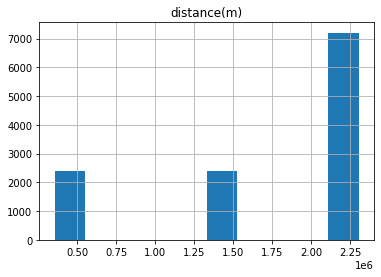

In [37]:
df_pred.hist('distance(m)')
plt.show()

In [38]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [39]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [1416816.4164298805, 1418218.516288185]
Segundo 2: [2302955.052465046, 2304269.2427004594]
Segundo 3: [2302908.941285051, 2304303.5869288566]
Segundo 4: [353463.59058958304, 354963.3491201944]
Segundo 5: [2125629.592009075, 2127042.3139649094]


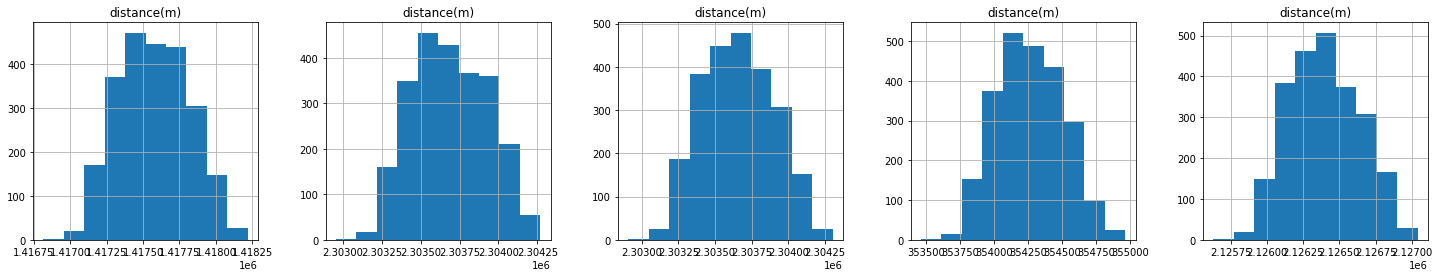

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [41]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,28.659857,1.488008,1.112224,-1.677137,-2.601807,41.396994,2.149619,184.171392,5.743007,0.164075,1.417575e+06
std,0.000826,0.000773,0.000448,0.000744,0.000268,0.002307,0.003671,98.232361,5.102721,1.308594,2.396238e+02
min,28.657515,1.483412,1.111138,-1.678157,-2.603922,41.390906,2.139125,0.939814,0.000000,-10.000000,1.416816e+06
25%,28.659495,1.487697,1.111855,-1.677707,-2.602034,41.395245,2.147242,101.919406,0.172846,-0.104516,1.417391e+06
50%,28.659858,1.488159,1.112217,-1.677244,-2.601772,41.396960,2.149929,155.247244,4.966377,0.000000,1.417570e+06
75%,28.660380,1.488622,1.112587,-1.676866,-2.601583,41.398961,2.151950,256.275266,10.340684,0.774525,1.417752e+06
max,28.664522,1.489107,1.114072,-1.665481,-2.600967,41.401814,2.158624,357.404922,16.640354,5.988961,1.418219e+06


In [42]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.699443,1.074983,-0.688901,-0.045500,0.260165,41.396996,2.149621,184.160835,5.890808,0.147801,2.303690e+06
std,0.000568,0.000572,0.000722,0.000830,0.000287,0.002308,0.003673,98.298534,4.947635,1.448525,2.404024e+02
min,20.697465,1.071736,-0.689837,-0.046233,0.259375,41.390873,2.139078,0.939814,0.000000,-10.000000,2.302955e+06
25%,20.699075,1.074751,-0.689361,-0.045893,0.259983,41.395234,2.147314,101.844412,0.968818,-0.154634,2.303503e+06
50%,20.699449,1.075153,-0.689157,-0.045867,0.260136,41.396960,2.149913,155.264593,5.239587,0.030756,2.303686e+06
75%,20.699766,1.075445,-0.688601,-0.045157,0.260278,41.398949,2.151951,256.443895,9.990617,0.898349,2.303882e+06
max,20.703360,1.075770,-0.681669,-0.039343,0.263404,41.401864,2.158743,358.402101,16.602367,5.993102,2.304269e+06


In [43]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.699729,1.075039,1.006472,0.226571,2.102137,41.396996,2.149623,184.186244,6.081826,0.191018,2.303658e+06
std,0.000621,0.000553,0.000573,0.000858,0.000545,0.002308,0.003675,98.566199,4.650839,1.636780,2.408612e+02
min,20.697699,1.071187,0.996469,0.215125,2.101094,41.390836,2.139009,0.373142,0.000000,-9.706740,2.302909e+06
25%,20.699432,1.074737,1.006238,0.226159,2.101770,41.395221,2.147382,103.263678,2.096294,-0.201319,2.303468e+06
50%,20.699733,1.075281,1.006461,0.226940,2.102152,41.396951,2.149961,155.606261,5.454008,0.089373,2.303666e+06
75%,20.700141,1.075330,1.006735,0.227006,2.102390,41.398932,2.151952,262.182490,9.341440,1.054450,2.303844e+06
max,20.703085,1.075676,1.009259,0.227583,2.105925,41.401915,2.158883,359.323010,16.546956,5.998546,2.304304e+06


In [44]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,38.213508,1.985996,0.342376,0.405496,-0.320892,41.396997,2.149625,183.173735,6.130936,0.049110,354264.099349
std,0.001067,0.000995,0.000854,0.000715,0.000690,0.002309,0.003675,99.410339,4.357840,1.918388,241.693257
min,38.210791,1.980108,0.335115,0.404416,-0.330861,41.390802,2.138863,2.280386,0.000000,-10.000000,353463.590590
25%,38.212850,1.985593,0.342445,0.405043,-0.321013,41.395206,2.147430,94.463904,2.726005,-0.410908,354076.822769
50%,38.213517,1.986249,0.342651,0.405458,-0.320885,41.396931,2.150051,160.120137,5.748746,0.085084,354249.973886
75%,38.214167,1.986812,0.342780,0.405674,-0.320705,41.398903,2.151970,268.070273,8.739849,1.113957,354440.261975
max,38.220440,1.987378,0.343105,0.411100,-0.316434,41.401967,2.158981,359.017348,16.626126,5.996870,354963.349120


In [45]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,22.292049,1.157755,0.542461,1.057760,-0.187722,41.396997,2.149628,176.707990,6.117309,0.105156,2.126400e+06
std,0.000673,0.000622,0.000819,0.001077,0.000848,0.002309,0.003675,100.425471,4.092248,1.903228,2.402726e+02
min,22.290262,1.154918,0.541507,1.043788,-0.202506,41.390767,2.138725,0.598478,0.000000,-10.000000,2.125630e+06
25%,22.291608,1.157350,0.542043,1.057272,-0.187867,41.395191,2.147420,74.637179,3.188963,-0.242367,2.126209e+06
50%,22.292083,1.157744,0.542129,1.058277,-0.187327,41.396900,2.150056,147.086299,6.220898,0.103251,2.126399e+06
75%,22.292470,1.158349,0.542505,1.058357,-0.187293,41.398873,2.151995,261.391452,8.441894,1.059701,2.126584e+06
max,22.296370,1.158748,0.555437,1.058520,-0.187027,41.402028,2.159084,359.352131,16.601876,5.982253,2.127042e+06


#### 2.1.1.3. Métricas del modelo

In [46]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_LSTM_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

In [54]:
# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 47
true_negative: 1153
Total colision: 1200
TP: 10
FN: 1190
Total no colision: 1200
FP: 47
TN: 1153

Accuracy: 0.4845833333333333
Precision: 0.17543859649122806
Recall: 0.008333333333333333
F1 Score: 0.015910898965791568
Specificity: 0.9608333333333333


In [55]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17920     
                                                                 
 dense_4 (Dense)             (None, 25)                1625      
                                                                 
 reshape_4 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 19,545
Trainable params: 19,545
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
(6005877, 20, 5)
(6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 20973s 223ms/step - loss: 1.1831 - mean_absolute_error: 23.0382 - val_loss: 279.5469 - val_mean_absolute_error: 39.5189 - lr: 0.0010
Epoch 2/10
93842/93842 [===

In [56]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 3s 35ms/step
Distance(m): [353500.27286083833, 2304137.907506875]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,28.659536,1.491232,1.632771,-0.666243,-1.422035,41.394340,2.151350,72.348077,0.000000,0.000000,1.417310e+06
1,20.700037,1.077814,-0.432974,-0.757800,-1.541398,41.394340,2.151350,72.348077,0.000000,0.000000,2.303324e+06
2,20.700355,1.077824,-2.389195,0.665299,-1.707903,41.394340,2.151350,72.348077,0.000000,0.000000,2.303289e+06
3,38.212655,1.983338,0.237080,0.514234,-0.898721,41.394340,2.151350,72.348077,0.000000,0.000000,3.540785e+05
4,22.292037,1.160523,0.410457,-0.055398,-0.740238,41.394340,2.151350,72.348077,0.000000,0.000000,2.126102e+06
...,...,...,...,...,...,...,...,...,...,...,...
12005,28.661623,1.490229,1.631476,-0.665433,-1.423142,41.400268,2.151179,44.652289,7.775367,0.289365,1.417739e+06
12006,20.701508,1.076952,-0.434211,-0.756619,-1.542265,41.400317,2.151234,39.488036,7.149873,-0.625495,2.303828e+06
12007,20.701296,1.076769,-2.390298,0.665957,-1.708602,41.400383,2.151277,23.947936,8.208109,1.058236,2.303860e+06
12008,38.214464,1.981796,0.238207,0.513057,-0.897749,41.400452,2.151264,348.255669,8.071555,-0.136553,3.545616e+05


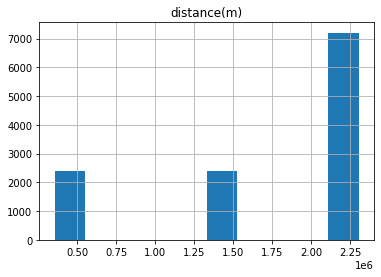

In [57]:
df_pred.hist('distance(m)')
plt.show()

In [58]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [59]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [1416741.4097952829, 1418145.9790589232]
Segundo 2: [2302805.1974425875, 2304137.907506875]
Segundo 3: [2302790.0224565156, 2304044.1962583587]
Segundo 4: [353500.27286083833, 354839.41386621393]
Segundo 5: [2125590.1669074087, 2126870.9450080465]


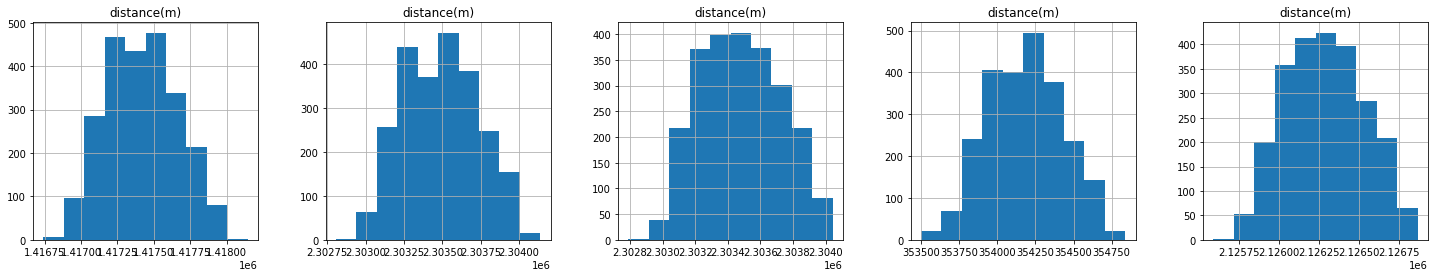

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [61]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,28.661232,1.489381,1.631291,-0.667932,-1.425369,41.396994,2.149619,184.171392,5.743007,0.164075,1.417417e+06
std,0.000691,0.001296,0.001056,0.001904,0.002591,0.002307,0.003671,98.232361,5.102721,1.308594,2.442356e+02
min,28.657763,1.485242,1.628378,-0.671794,-1.430751,41.390906,2.139125,0.939814,0.000000,-10.000000,1.416741e+06
25%,28.660761,1.488363,1.630406,-0.669646,-1.427748,41.395245,2.147242,101.919406,0.172846,-0.104516,1.417225e+06
50%,28.661286,1.489455,1.631285,-0.667501,-1.424807,41.396960,2.149929,155.247244,4.966377,0.000000,1.417420e+06
75%,28.661623,1.490553,1.632243,-0.666264,-1.422968,41.398961,2.151950,256.275266,10.340684,0.774525,1.417597e+06
max,28.663679,1.491856,1.633408,-0.663912,-1.421719,41.401814,2.158624,357.404922,16.640354,5.988961,1.418146e+06


In [62]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.701189,1.076446,-0.432800,-0.758522,-1.540460,41.396996,2.149621,184.160835,5.890808,0.147801,2.303490e+06
std,0.000517,0.000931,0.000782,0.001262,0.001359,0.002308,0.003673,98.298534,4.947635,1.448525,2.448408e+02
min,20.698755,1.073537,-0.435045,-0.761100,-1.543487,41.390873,2.139078,0.939814,0.000000,-10.000000,2.302805e+06
25%,20.700869,1.075684,-0.433059,-0.759671,-1.541538,41.395234,2.147314,101.844412,0.968818,-0.154634,2.303301e+06
50%,20.701227,1.076522,-0.432559,-0.758181,-1.540800,41.396960,2.149913,155.264593,5.239587,0.030756,2.303491e+06
75%,20.701491,1.077352,-0.432301,-0.757794,-1.539205,41.398949,2.151951,256.443895,9.990617,0.898349,2.303675e+06
max,20.702945,1.078102,-0.430936,-0.755366,-1.537704,41.401864,2.158743,358.402101,16.602367,5.993102,2.304138e+06


In [63]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.701283,1.076419,-2.391274,0.668107,-1.709363,41.396996,2.149623,184.186244,6.081826,0.191018,2.303480e+06
std,0.000484,0.000916,0.001722,0.002061,0.001314,0.002308,0.003675,98.566199,4.650839,1.636780,2.447915e+02
min,20.699900,1.073481,-2.394787,0.665265,-1.712036,41.390836,2.139009,0.373142,0.000000,-9.706740,2.302790e+06
25%,20.700981,1.075663,-2.392811,0.666281,-1.710534,41.395221,2.147382,103.263678,2.096294,-0.201319,2.303289e+06
50%,20.701294,1.076486,-2.391026,0.667633,-1.709178,41.396951,2.149961,155.606261,5.454008,0.089373,2.303488e+06
75%,20.701658,1.077342,-2.389798,0.669995,-1.708210,41.398932,2.151952,262.182490,9.341440,1.054450,2.303667e+06
max,20.702744,1.077935,-2.387436,0.672235,-1.706473,41.401915,2.158883,359.323010,16.546956,5.998546,2.304044e+06


In [64]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,38.214387,1.980775,0.237927,0.512678,-0.895773,41.396997,2.149625,183.173735,6.130936,0.049110,354184.253501
std,0.000934,0.001695,0.000546,0.001159,0.002104,0.002309,0.003675,99.410339,4.357840,1.918388,247.240309
min,38.211793,1.975692,0.236797,0.509392,-0.898748,41.390802,2.138863,2.280386,0.000000,-10.000000,353500.272861
25%,38.213833,1.979396,0.237507,0.511700,-0.897808,41.395206,2.147430,94.463904,2.726005,-0.410908,354001.906779
50%,38.214431,1.980926,0.237851,0.512705,-0.896260,41.396931,2.150051,160.120137,5.748746,0.085084,354189.602723
75%,38.215075,1.982389,0.238376,0.513839,-0.893849,41.398903,2.151970,268.070273,8.739849,1.113957,354348.804631
max,38.217245,1.983921,0.240095,0.514614,-0.891534,41.401967,2.158981,359.017348,16.626126,5.996870,354839.413866


In [65]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,22.293008,1.159092,0.409818,-0.052820,-0.740935,41.396997,2.149628,176.707990,6.117309,0.105156,2.126288e+06
std,0.000532,0.001009,0.000644,0.001497,0.001002,0.002309,0.003675,100.425471,4.092248,1.903228,2.449057e+02
min,22.291340,1.156091,0.408401,-0.055427,-0.742987,41.390767,2.138725,0.598478,0.000000,-10.000000,2.125590e+06
25%,22.292705,1.158268,0.409325,-0.054190,-0.741742,41.395191,2.147420,74.637179,3.188963,-0.242367,2.126099e+06
50%,22.293037,1.159186,0.409719,-0.053099,-0.740912,41.396900,2.150056,147.086299,6.220898,0.103251,2.126295e+06
75%,22.293402,1.160067,0.410144,-0.051511,-0.740513,41.398873,2.151995,261.391452,8.441894,1.059701,2.126473e+06
max,22.294634,1.160915,0.412652,-0.049005,-0.738015,41.402028,2.159084,359.352131,16.601876,5.982253,2.126871e+06


In [66]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

In [67]:
# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 37
true_negative: 1163
Total colision: 1200
TP: 6
FN: 1194
Total no colision: 1200
FP: 37
TN: 1163

Accuracy: 0.4870833333333333
Precision: 0.13953488372093023
Recall: 0.005
F1 Score: 0.009654062751407884
Specificity: 0.9691666666666666


In [15]:
def make_gru_model(units, in_steps, out_steps, in_features, out_features):
    gru_model = Sequential()

    # Shape [batch, time, in_features] => [batch, gru_units].
    gru_model.add(GRU(units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    gru_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    gru_model.add(Reshape([out_steps, out_features]))

    gru_model.summary()

    return gru_model

In [69]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_GRU_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=32

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dense_5 (Dense)             (None, 25)                825       
                                                                 
 reshape_5 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 4,569
Trainable params: 4,569
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
(6005877, 20, 5)
(6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 12636s 135ms/step - loss: 2.7838 - mean_absolute_error: 22.8004 - val_loss: 279.5669 - val_mean_absolute_error: 39.2634 - lr: 0.0010
Epoch 2/10
93842/93842 [=====

In [70]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 30ms/step
Distance(m): [353612.25510978804, 2304493.967156389]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,28.658757,1.489391,0.595083,-0.451394,0.655217,41.394340,2.151350,72.348077,0.000000,0.000000,1.417403e+06
1,20.697461,1.075848,2.078862,-2.262325,-0.265868,41.394340,2.151350,72.348077,0.000000,0.000000,2.303619e+06
2,20.697836,1.075574,2.293064,-0.858423,0.669502,41.394340,2.151350,72.348077,0.000000,0.000000,2.303578e+06
3,38.210709,1.985782,0.351133,0.265969,1.333032,41.394340,2.151350,72.348077,0.000000,0.000000,3.542863e+05
4,22.290014,1.158621,0.601080,0.730308,-1.356489,41.394340,2.151350,72.348077,0.000000,0.000000,2.126334e+06
...,...,...,...,...,...,...,...,...,...,...,...
12005,28.661181,1.487324,0.613186,-0.459731,0.646428,41.400268,2.151179,44.652289,7.775367,0.289365,1.417800e+06
12006,20.699446,1.074300,2.058197,-2.268259,-0.268914,41.400317,2.151234,39.488036,7.149873,-0.625495,2.304068e+06
12007,20.699366,1.074274,2.278294,-0.868336,0.641084,41.400383,2.151277,23.947936,8.208109,1.058236,2.304084e+06
12008,38.213887,1.983098,0.351020,0.281486,1.306842,41.400452,2.151264,348.255669,8.071555,-0.136553,3.546212e+05


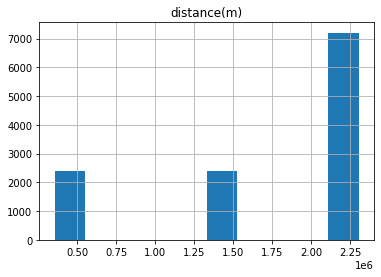

In [71]:
df_pred.hist('distance(m)')
plt.show()

In [72]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [73]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [1416809.9978274123, 1418349.6115366016]
Segundo 2: [2303064.905748457, 2304493.967156389]
Segundo 3: [2303069.56979037, 2304440.88820875]
Segundo 4: [353612.25510978804, 355270.48937851505]
Segundo 5: [2125779.7313909302, 2127300.4569180007]


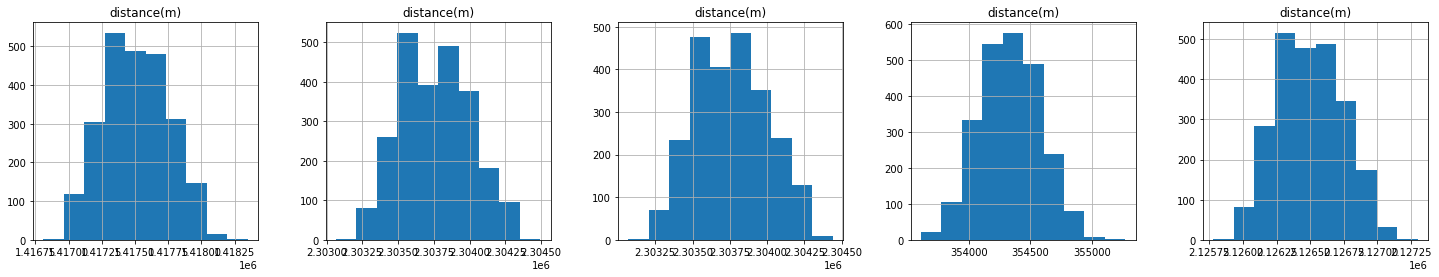

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [75]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,28.660432,1.487752,0.593526,-0.448939,0.653883,41.396994,2.149619,184.171392,5.743007,0.164075,1.417512e+06
std,0.000701,0.001027,0.019196,0.010537,0.007536,0.002307,0.003671,98.232361,5.102721,1.308594,2.411595e+02
min,28.655789,1.483595,0.558337,-0.477698,0.629248,41.390906,2.139125,0.939814,0.000000,-10.000000,1.416810e+06
25%,28.660146,1.487003,0.580268,-0.459174,0.646167,41.395245,2.147242,101.919406,0.172846,-0.104516,1.417328e+06
50%,28.660540,1.487863,0.588261,-0.445950,0.655473,41.396960,2.149929,155.247244,4.966377,0.000000,1.417520e+06
75%,28.660904,1.488719,0.612528,-0.441146,0.658859,41.398961,2.151950,256.275266,10.340684,0.774525,1.417684e+06
max,28.661792,1.490400,0.648399,-0.430174,0.667478,41.401814,2.158624,357.404922,16.640354,5.988961,1.418350e+06


In [76]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.698835,1.074542,2.085234,-2.263135,-0.266069,41.396996,2.149621,184.160835,5.890808,0.147801,2.303759e+06
std,0.000528,0.000712,0.026308,0.005039,0.002765,0.002308,0.003673,98.298534,4.947635,1.448525,2.418714e+02
min,20.695705,1.071792,2.014759,-2.279166,-0.274455,41.390873,2.139078,0.939814,0.000000,-10.000000,2.303065e+06
25%,20.698593,1.074035,2.059953,-2.268304,-0.268870,41.395234,2.147314,101.844412,0.968818,-0.154634,2.303569e+06
50%,20.698849,1.074604,2.092677,-2.261886,-0.265372,41.396960,2.149913,155.264593,5.239587,0.030756,2.303759e+06
75%,20.699180,1.075191,2.104783,-2.259795,-0.264243,41.398949,2.151951,256.443895,9.990617,0.898349,2.303938e+06
max,20.699964,1.076349,2.132472,-2.254171,-0.260998,41.401864,2.158743,358.402101,16.602367,5.993102,2.304494e+06


In [77]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.698820,1.074501,2.298705,-0.852659,0.676649,41.396996,2.149623,184.186244,6.081826,0.191018,2.303761e+06
std,0.000475,0.000743,0.019842,0.015131,0.034559,0.002308,0.003675,98.566199,4.650839,1.636780,2.432649e+02
min,20.696074,1.071580,2.246611,-0.889192,0.582900,41.390836,2.139009,0.373142,0.000000,-9.706740,2.303070e+06
25%,20.698552,1.073965,2.279762,-0.866474,0.643424,41.395221,2.147382,103.263678,2.096294,-0.201319,2.303566e+06
50%,20.698800,1.074590,2.304283,-0.848863,0.686343,41.396951,2.149961,155.606261,5.454008,0.089373,2.303761e+06
75%,20.699168,1.075204,2.313663,-0.840804,0.702036,41.398932,2.151952,262.182490,9.341440,1.054450,2.303942e+06
max,20.700225,1.076441,2.334215,-0.825724,0.738929,41.401915,2.158883,359.323010,16.546956,5.998546,2.304441e+06


In [78]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,38.212932,1.983607,0.350355,0.259373,1.338950,41.396997,2.149625,183.173735,6.130936,0.049110,354336.169188
std,0.000928,0.001381,0.000680,0.021349,0.031155,0.002309,0.003675,99.410339,4.357840,1.918388,243.057369
min,38.207174,1.978018,0.349333,0.221018,1.254259,41.390802,2.138863,2.280386,0.000000,-10.000000,353612.255110
25%,38.212565,1.982609,0.349785,0.243021,1.308989,41.395206,2.147430,94.463904,2.726005,-0.410908,354156.978158
50%,38.213131,1.983760,0.350320,0.253682,1.347665,41.396931,2.150051,160.120137,5.748746,0.085084,354342.672071
75%,38.213559,1.984920,0.350884,0.279360,1.361803,41.398903,2.151970,268.070273,8.739849,1.113957,354498.860569
max,38.214634,1.987207,0.352151,0.313463,1.395157,41.401967,2.158981,359.017348,16.626126,5.996870,355270.489379


In [79]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,22.291181,1.157326,0.595959,0.726280,-1.354153,41.396997,2.149628,176.707990,6.117309,0.105156,2.126498e+06
std,0.000545,0.000809,0.034613,0.011654,0.028134,0.002309,0.003675,100.425471,4.092248,1.903228,2.430419e+02
min,22.287199,1.153855,0.532806,0.705150,-1.435187,41.390767,2.138725,0.598478,0.000000,-10.000000,2.125780e+06
25%,22.290908,1.156753,0.571175,0.717397,-1.382061,41.395191,2.147420,74.637179,3.188963,-0.242367,2.126308e+06
50%,22.291285,1.157437,0.586282,0.723213,-1.346530,41.396900,2.150056,147.086299,6.220898,0.103251,2.126506e+06
75%,22.291568,1.158118,0.629613,0.737165,-1.334761,41.398873,2.151995,261.391452,8.441894,1.059701,2.126676e+06
max,22.292157,1.159488,0.691878,0.755428,-1.302566,41.402028,2.159084,359.352131,16.601876,5.982253,2.127300e+06


In [80]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_GRU_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

In [81]:
# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 80
true_negative: 1120
Total colision: 1200
TP: 22
FN: 1178
Total no colision: 1200
FP: 80
TN: 1120

Accuracy: 0.47583333333333333
Precision: 0.21568627450980393
Recall: 0.018333333333333333
F1 Score: 0.033794162826420886
Specificity: 0.9333333333333333


In [16]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_GRU_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=64

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13632     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 15,257
Trainable params: 15,257
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
(6005877, 20, 5)
(6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 15277s 163ms/step - loss: 1.1502 - mean_absolute_error: 23.1159 - val_loss: 279.6242 - val_mean_absolute_error: 39.5853 - lr: 0.0010
Epoch 2/10
93842/93842 [=====

In [17]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 27ms/step
Distance(m): [353499.53986115084, 2303911.5757935224]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,28.658670,1.492442,0.903140,-0.344654,-0.617616,41.394340,2.151350,72.348077,0.000000,0.000000,1.417401e+06
1,20.701284,1.077879,-0.938169,0.103754,1.657635,41.394340,2.151350,72.348077,0.000000,0.000000,2.303186e+06
2,20.701869,1.077895,-1.790760,2.642662,1.328845,41.394340,2.151350,72.348077,0.000000,0.000000,2.303120e+06
3,38.212322,1.983641,0.279385,0.795533,1.852090,41.394340,2.151350,72.348077,0.000000,0.000000,3.541144e+05
4,22.292558,1.160700,-0.910554,1.108985,-0.344306,41.394340,2.151350,72.348077,0.000000,0.000000,2.126043e+06
...,...,...,...,...,...,...,...,...,...,...,...
12005,28.660908,1.490699,0.904138,-0.341974,-0.616235,41.400268,2.151179,44.652289,7.775367,0.289365,1.417817e+06
12006,20.702848,1.076666,-0.939593,0.106569,1.655904,41.400317,2.151234,39.488036,7.149873,-0.625495,2.303680e+06
12007,20.703322,1.076663,-1.789743,2.645494,1.329025,41.400383,2.151277,23.947936,8.208109,1.058236,2.303635e+06
12008,38.215299,1.981100,0.279003,0.793664,1.854709,41.400452,2.151264,348.255669,8.071555,-0.136553,3.544713e+05


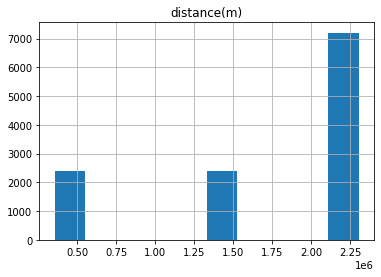

In [18]:
df_pred.hist('distance(m)')
plt.show()

In [19]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [20]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [1416837.3104160111, 1418101.8254821699]
Segundo 2: [2302660.1691015535, 2303911.5757935224]
Segundo 3: [2302622.2620941913, 2303880.967352858]
Segundo 4: [353499.53986115084, 354808.8772746325]
Segundo 5: [2125530.464829426, 2126808.712435763]


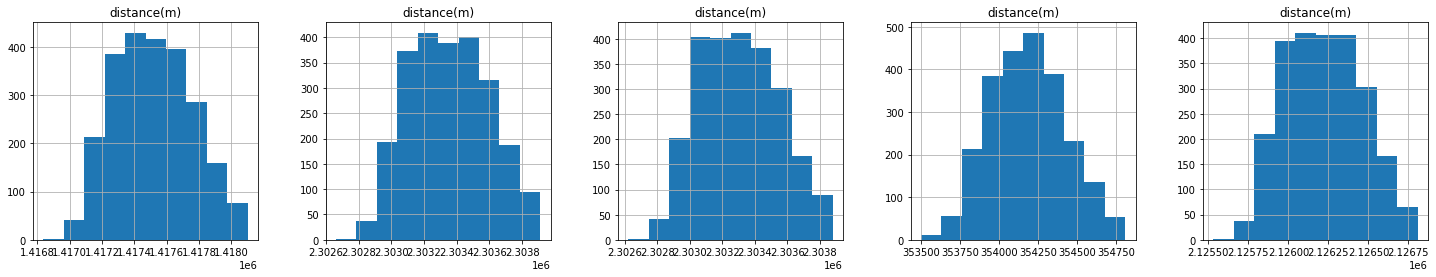

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [22]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,28.660257,1.491069,0.904804,-0.341130,-0.616254,41.396994,2.149619,184.171392,5.743007,0.164075,1.417518e+06
std,0.000700,0.001155,0.001209,0.002075,0.001060,0.002307,0.003671,98.232361,5.102721,1.308594,2.383873e+02
min,28.658253,1.486713,0.899158,-0.350060,-0.620125,41.390906,2.139125,0.939814,0.000000,-10.000000,1.416837e+06
25%,28.659887,1.490361,0.904481,-0.341773,-0.617047,41.395245,2.147242,101.919406,0.172846,-0.104516,1.417333e+06
50%,28.660240,1.491203,0.905242,-0.340596,-0.616488,41.396960,2.149929,155.247244,4.966377,0.000000,1.417523e+06
75%,28.660698,1.492103,0.905621,-0.339812,-0.615632,41.398961,2.151950,256.275266,10.340684,0.774525,1.417690e+06
max,28.663141,1.493054,0.906924,-0.336701,-0.611995,41.401814,2.158624,357.404922,16.640354,5.988961,1.418102e+06


In [23]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.702424,1.076887,-0.941254,0.106583,1.655675,41.396996,2.149621,184.160835,5.890808,0.147801,2.303351e+06
std,0.000479,0.000814,0.002384,0.001376,0.000966,0.002308,0.003673,98.298534,4.947635,1.448525,2.415809e+02
min,20.700882,1.073730,-0.948032,0.102330,1.653594,41.390873,2.139078,0.939814,0.000000,-10.000000,2.302660e+06
25%,20.702176,1.076399,-0.942716,0.105681,1.655052,41.395234,2.147314,101.844412,0.968818,-0.154634,2.303159e+06
50%,20.702441,1.076990,-0.941441,0.106363,1.655431,41.396960,2.149913,155.264593,5.239587,0.030756,2.303353e+06
75%,20.702747,1.077610,-0.940566,0.107530,1.655964,41.398949,2.151951,256.443895,9.990617,0.898349,2.303534e+06
max,20.704095,1.078259,-0.926725,0.111171,1.659856,41.401864,2.158743,358.402101,16.602367,5.993102,2.303912e+06


In [24]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,20.702834,1.076883,-1.790775,2.645881,1.327623,41.396996,2.149623,184.186244,6.081826,0.191018,2.303305e+06
std,0.000484,0.000812,0.000878,0.001835,0.001541,0.002308,0.003675,98.566199,4.650839,1.636780,2.410711e+02
min,20.701815,1.073785,-1.792158,2.640423,1.324059,41.390836,2.139009,0.373142,0.000000,-9.706740,2.302622e+06
25%,20.702545,1.076391,-1.791372,2.644627,1.326605,41.395221,2.147382,103.263678,2.096294,-0.201319,2.303113e+06
50%,20.702774,1.076993,-1.790926,2.645496,1.327258,41.396951,2.149961,155.606261,5.454008,0.089373,2.303306e+06
75%,20.703163,1.077596,-1.790561,2.647117,1.328302,41.398932,2.151952,262.182490,9.341440,1.054450,2.303484e+06
max,20.704944,1.078279,-1.783171,2.652615,1.337535,41.401915,2.158883,359.323010,16.546956,5.998546,2.303881e+06


In [25]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,38.214370,1.981469,0.278972,0.794584,1.855103,41.396997,2.149625,183.173735,6.130936,0.049110,354183.712065
std,0.000934,0.001508,0.000283,0.000718,0.001679,0.002309,0.003675,99.410339,4.357840,1.918388,238.291457
min,38.211983,1.975620,0.278200,0.789271,1.849887,41.390802,2.138863,2.280386,0.000000,-10.000000,353499.539861
25%,38.213843,1.980529,0.278779,0.794194,1.854063,41.395206,2.147430,94.463904,2.726005,-0.410908,354006.993779
50%,38.214292,1.981698,0.278928,0.794774,1.855139,41.396931,2.150051,160.120137,5.748746,0.085084,354188.212641
75%,38.214973,1.982744,0.279146,0.795077,1.856220,41.398903,2.151970,268.070273,8.739849,1.113957,354341.527685
max,38.218210,1.984676,0.280343,0.795663,1.860699,41.401967,2.158981,359.017348,16.626126,5.996870,354808.877275


In [26]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2.402000e+03
mean,22.293589,1.159466,-0.910824,1.112661,-0.342002,41.396997,2.149628,176.707990,6.117309,0.105156,2.126222e+06
std,0.000516,0.000860,0.000400,0.002155,0.001582,0.002309,0.003675,100.425471,4.092248,1.903228,2.409867e+02
min,22.292415,1.156128,-0.912381,1.104078,-0.348544,41.390767,2.138725,0.598478,0.000000,-10.000000,2.125530e+06
25%,22.293286,1.158936,-0.911058,1.111430,-0.343161,41.395191,2.147420,74.637179,3.188963,-0.242367,2.126031e+06
50%,22.293537,1.159597,-0.910773,1.112433,-0.342637,41.396900,2.150056,147.086299,6.220898,0.103251,2.126224e+06
75%,22.293943,1.160198,-0.910561,1.114095,-0.340993,41.398873,2.151995,261.391452,8.441894,1.059701,2.126397e+06
max,22.295729,1.161343,-0.908543,1.120241,-0.335718,41.402028,2.159084,359.352131,16.601876,5.982253,2.126809e+06


In [27]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple", "UKF_PINN_GRU_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

In [28]:
# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 30
true_negative: 1170
Total colision: 1200
TP: 7
FN: 1193
Total no colision: 1200
FP: 30
TN: 1170

Accuracy: 0.49041666666666667
Precision: 0.1891891891891892
Recall: 0.005833333333333334
F1 Score: 0.01131770412287793
Specificity: 0.975
